# U-Net Implementation From Scratch

Here I'm going to be using a different biomedical dataset because I couldn't download the one used in the original from.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

import os
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Model Architecture

In [23]:
# Encoder / Contracting Path
class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
    
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    def forward(self, x):
        feat = self.conv(x) # The skip connection
        out = self.pool(feat) # The input for the next layer
        return feat, out

In [24]:
# Bottleneck
class Bottleneck(nn.Module):
    def __init__(self):
        super(Bottleneck, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x):
        return self.conv(x)

In [25]:
def center_crop(enc_feat, target_tensor):
    _, _, h, w = target_tensor.shape
    enc_h, enc_w = enc_feat.shape[2], enc_feat.shape[3]

    delta_h = enc_h - h
    delta_w = enc_w - w

    return enc_feat[:, :, delta_h // 2 : enc_h - delta_h // 2, delta_w // 2 : enc_w - delta_w // 2]

In [26]:
# Decoder / Expanding Path
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()

        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        self.conv = nn.Sequential(
            nn.Conv2d(out_channels * 2, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=2),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=2),
        )
    
    def forward(self, x, enc_feat):
        x = self.upconv(x)
        enc_feat = center_crop(enc_feat, x)
        x = torch.cat([enc_feat, x], dim=1)
        return self.conv(x)

In [27]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1):
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = Encoder(in_channels, 64)
        self.enc2 = Encoder(64, 128)
        self.enc3 = Encoder(128, 256)
        self.enc4 = Encoder(256, 512)

        # Bottleneck
        self.bottleneck = Bottleneck()

        # Decoder
        self.dec4 = Decoder(1024, 512)
        self.dec3 = Decoder(512, 256)
        self.dec2 = Decoder(256, 128)
        self.dec1 = Decoder(128, 64)

        # Final Conv 1x1
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)


    def forward(self, x):
        s1, p1 = self.enc1(x)
        s2, p2 = self.enc2(p1)
        s3, p3 = self.enc3(p2)
        s4, p4 = self.enc4(p3)

        b = self.bottleneck(p4)

        d4 = self.dec4(b, s4)
        d3 = self.dec3(d4, s3)
        d2 = self.dec2(d3, s2)
        d1 = self.dec1(d2, s1)

        return self.final(d1)


# Dataset Class

In [9]:
class LungDataset(Dataset):
    def __init__(self, image_path, mask_path, image_transform=None, mask_transform=None):
        self.image_path = image_path
        self.mask_path = mask_path
        self.image_filenames = sorted(os.listdir(image_path))
        self.mask_filenames = sorted(os.listdir(mask_path))
        self.image_transform =image_transform
        self.mask_transform = mask_transform


    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, index):
        image_dir = os.path.join(self.image_path, self.image_filenames[index])
        mask_dir = os.path.join(self.mask_path, self.mask_filenames[index])

        image = Image.open(image_dir).convert('RGB')
        mask = Image.open(mask_dir).convert('L')

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        # Removes the extra '1' channel dimension (changes shape from [1, H, W] to [H, W])
        mask = mask.squeeze(0)
        # Ensures all pixels are strictly 0 or 1, cleaning up any blurry gray edges caused by transforms
        mask = torch.where(mask > 0, 1, 0).float()

        return image, mask

# Helper Functions

In [10]:
def get_transforms():
    image_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    mask_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    return image_transform, mask_transform

In [19]:
def get_loaders(image_path, mask_path):
    image_transform, mask_transform = get_transforms()

    dataset = LungDataset(
        image_path, 
        mask_path, 
        image_transform=image_transform, 
        mask_transform=mask_transform
    )

    # Split dataset into train/val
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size

    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset,
        [train_size, val_size]
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=1,
        shuffle=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=1,
        shuffle=False
    )

    return train_loader, val_loader

In [12]:
def training_setup(model):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    return criterion, optimizer

In [13]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0.0

    correct_pixels = 0.0
    total_pixels = 0.0

    for images, masks in loader:
        # masks shape becomes [Batch, 1, H, W] to match model output
        images, masks = images.to(device), masks.to(device).unsqueeze(1)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, masks)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Convert model outputs to binary predictions (0 or 1)
        preds = (torch.sigmoid(output) > 0.5).float()

        # This creates a boolean tensor where True represents a correct pixel match.
        correct_pixels += (preds == masks).sum().item()

        # Add the total number of pixels in this batch to our running total
        total_pixels += torch.numel(preds)
    
    epoch_loss /= len(loader)
    epoch_acc = correct_pixels / total_pixels
    return epoch_acc, epoch_loss

In [14]:
def validate(model, loader, criterion, device):
    model.eval()
    epoch_loss = 0.0

    correct_pixels = 0.0
    total_pixels = 0.0

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device).unsqueeze(1)

            output = model(images)
            loss = criterion(output, masks)

            epoch_loss += loss.item()

            preds = (torch.sigmoid(output) > 0.5).float()
            correct_pixels += (preds == masks).sum().item()
            total_pixels += torch.numel(preds)
    
    epoch_loss /= len(loader)
    epoch_acc = correct_pixels / total_pixels

    return epoch_acc, epoch_loss

In [15]:
def plot_learning_curves(train_history, val_history):
    
    epochs = range(1, len(train_history['loss']) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Loss
    ax1.plot(epochs, train_history['loss'], label='Train Loss', color='blue', marker='o', markersize=4)
    ax1.plot(epochs, val_history['loss'], label='Val Loss', color='red', marker='o', markersize=4)
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Plot 2: Accuracy
    ax2.plot(epochs, train_history['acc'], label='Train Accuracy', color='blue', marker='o', markersize=4)
    ax2.plot(epochs, val_history['acc'], label='Val Accuracy', color='red', marker='o', markersize=4)
    ax2.set_title('Training and Validation Pixel Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# Train Model

In [28]:
model = UNet().to(device)
criterion, optimizer = training_setup(model)

images_path = "/content/drive/MyDrive/Chest X-Ray Dataset/images"
masks_path = "/content/drive/MyDrive/Chest X-Ray Dataset/masks"

train_loader, val_loader = get_loaders(images_path, masks_path)

In [29]:
train_history = {"acc":[], "loss":[]}
val_history = {"acc":[], "loss":[]}

EPOCHS = 50
for epoch in range(EPOCHS):
    train_pixel_acc, train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_pixel_acc, val_loss = validate(model, val_loader, criterion, device)

    train_history["acc"].append(train_pixel_acc)
    train_history["loss"].append(train_loss)

    val_history['acc'].append(val_pixel_acc)
    val_history['loss'].append(val_loss)

    print(f"Epoch: {epoch+1}/{EPOCHS} | "
          f"Training Loss: {train_loss} | Training Pixel Accuracy: {train_pixel_acc} | "
          f"Validation Loss: {val_loss} | Validation Pixel Accuracy: {val_pixel_acc}")


Epoch: 1/50 | Training Loss: 0.582299618422985 | Training Pixel Accuracy: 0.7331270217895508 | Validation Loss: 0.4881090700626373 | Validation Pixel Accuracy: 0.765899658203125
Epoch: 2/50 | Training Loss: 0.47797175757586957 | Training Pixel Accuracy: 0.7663415908813477 | Validation Loss: 0.46000549495220183 | Validation Pixel Accuracy: 0.7846534729003907
Epoch: 3/50 | Training Loss: 0.4844565480947495 | Training Pixel Accuracy: 0.7649105072021485 | Validation Loss: 0.4656253278255463 | Validation Pixel Accuracy: 0.7736557006835938
Epoch: 4/50 | Training Loss: 0.4632140096276999 | Training Pixel Accuracy: 0.7872608184814454 | Validation Loss: 0.44915488809347154 | Validation Pixel Accuracy: 0.7923820495605469
Epoch: 5/50 | Training Loss: 0.4496308196336031 | Training Pixel Accuracy: 0.7936038970947266 | Validation Loss: 0.45427345484495163 | Validation Pixel Accuracy: 0.788104248046875
Epoch: 6/50 | Training Loss: 0.4313291085883975 | Training Pixel Accuracy: 0.8096153259277343 | Val

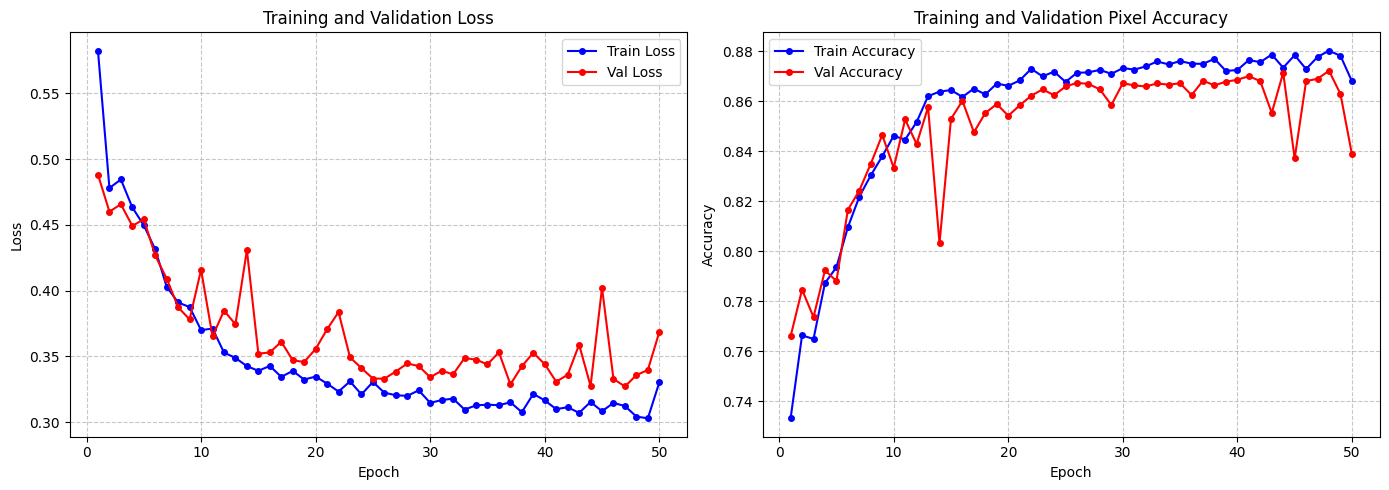

In [30]:
plot_learning_curves(train_history, val_history)